![title](https://avatars.mds.yandex.net/i?id=4ab49965b2f81da1e2c5ed84bdfcd11f_sr-5175011-images-thumbs&n=13)

# Промышленность - моделирование температуры стали

## Исследовательский анализ данных

#### Импорт библиотек

In [2]:
# установим свежие версии библиотек
!pip install pandas==1.4.3
!pip install matplotlib==3.5.2
!pip install missingno

     |████████████████████████████████| 11.7 MB 1.4 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.4
    Uninstalling pandas-1.2.4:
      Successfully uninstalled pandas-1.2.4
     |████████████████████████████████| 11.2 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 965 kB 80.8 MB/s eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

import catboost
from catboost import CatBoostRegressor

import keras
from keras import layers
from tqdm.keras import TqdmCallback
from tensorflow.keras.optimizers import RMSprop

import seaborn as sns
import missingno

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

In [4]:
print('catboost version', catboost.__version__)

catboost version 1.0.3


---
#### Импорт данных

In [5]:
# локальный путь
dataset_dir = './datasets/final_steel/' 

# сетевой путь
if not os.path.isdir(dataset_dir): dataset_dir = '/datasets/final_steel/'


# Словарь для сохранения всех импортированных таблиц
data_dict = {}

# Список названий файлов для импорта. 
# Эти названия буду ключами в словаре data_dict
tables = ['data_arc',
          'data_bulk',
          'data_bulk_time',
          'data_gas',
          'data_temp',
          'data_wire',
          'data_wire_time'
         ]

# Заполняем словарь импортированными данными из таблиц
for table_name in tables:
    try:
        data_dict[table_name] =  pd.read_csv(dataset_dir + table_name + '.csv')
        data_dict[table_name]['table_name'] = table_name
        # в значениях не требуется двойная точность, так что
        # сразу импортируем все float колонки в формате float32 
        # это необходимо для сокращения объема вычислений при оптимизации модели
        
        df_float = data_dict[table_name].select_dtypes(include=float).astype("float32")
        df_not_float = data_dict[table_name].select_dtypes(exclude=float)
        data_dict[table_name] = df_float.join(df_not_float)
        
        print(f'Imported {table_name}.csv ')
    except:
        print(f'\033[91mError importing file {table_name}.csv')
        break
        

Imported data_arc.csv 
Imported data_bulk.csv 
Imported data_bulk_time.csv 
Imported data_gas.csv 
Imported data_temp.csv 
Imported data_wire.csv 
Imported data_wire_time.csv 


---
### Исследование таблиц

In [6]:
# функция для отображения данных по каждой из таблиц
def describe_table(df):

    print('\033[94m\x1B[1m' ,'\nПервые строки таблицы:' , '\x1b[0m')
    display(df.head(3))
    
    print('\033[94m\x1B[1m' ,'\nФорматы данных:' , '\x1b[0m')
    print(df.info())
    
    print('\n\033[94m\x1B[1m' ,'\nDescribe числовых данных таблицы:' , '\x1b[0m')
    display(df.describe().T)
    
    
    for column in df.drop(columns=['key']).columns:
        try:
            df[column].plot(kind='hist', bins=100, figsize=(5,0.8))
            plt.title(column)
            plt.show()
        except:
            pass
    
    # прочая информация
    batches = len(df['key'].unique())
    lines = len(df)              
    print('\033[94m\x1B[1m')
    print('Прочая информация:' , '\x1b[0m')
    print('Уникальных партий:',batches)
    print('Среднее количество записей на 1 партию:',round(lines / batches,2))
    print('Дубликатов:',df.duplicated().sum())
    print('Пропусков:\n')
    print(df.isnull().sum())

---
<span style="color:blue">  
    
#### Таблица `data_arc`

Данные об электродах

 
Первые строки таблицы: 


,Активная мощность,Реактивная мощность,key,Начало нагрева дугой,Конец нагрева дугой,table_name
0,0.976059,0.687084,1,2019-05-03 11:02:14,2019-05-03 11:06:02,data_arc
1,0.805607,0.520285,1,2019-05-03 11:07:28,2019-05-03 11:10:33,data_arc
2,0.744363,0.498805,1,2019-05-03 11:11:44,2019-05-03 11:14:36,data_arc


 
Форматы данных: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Активная мощность     14876 non-null  float32
 1   Реактивная мощность   14876 non-null  float32
 2   key                   14876 non-null  int64  
 3   Начало нагрева дугой  14876 non-null  object 
 4   Конец нагрева дугой   14876 non-null  object 
 5   table_name            14876 non-null  object 
dtypes: float32(2), int64(1), object(3)
memory usage: 581.2+ KB
None

 
Describe числовых данных таблицы: 


,count,mean,std,min,25%,50%,75%,max
Активная мощность,14876.0,0.670442,0.408159,0.030002,0.395297,0.555517,0.857034,3.731596
Реактивная мощность,14876.0,0.452592,5.878702,-715.504944,0.290991,0.415962,0.637371,2.676388
key,14876.0,1615.220422,934.571502,1.000000,806.000000,1617.000000,2429.000000,3241.000000


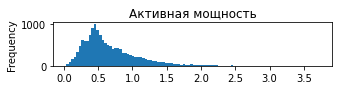

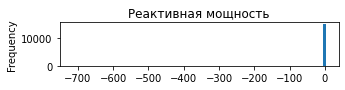


Прочая информация: 
Уникальных партий: 3214
Среднее количество записей на 1 партию: 4.63
Дубликатов: 0
Пропусков:

Активная мощность       0
Реактивная мощность     0
key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
table_name              0
dtype: int64


In [7]:
tbl='data_arc'
describe_table(data_dict[tbl])

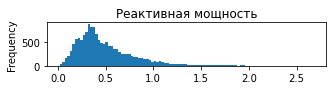

In [8]:
# скорректируем выбросы реактивной мощности медианным значением
column = 'Реактивная мощность'
data_dict[tbl].loc[data_dict[tbl][column]<0, column] = data_dict.get(tbl)[column].median()
data_dict[tbl][column].plot(kind='hist', bins=100, figsize=(5,0.8),title=column);

In [9]:
# приведем формат времени к datetime
data_dict[tbl]['Начало нагрева дугой'] = pd.to_datetime( data_dict[tbl]['Начало нагрева дугой'])
data_dict[tbl]['Конец нагрева дугой'] = pd.to_datetime( data_dict[tbl]['Конец нагрева дугой'])

# добавим колонки калькулируемые колонки
data_dict[tbl]['arc_duration'] = (data_dict[tbl]['Конец нагрева дугой'] 
                                  - data_dict[tbl]['Начало нагрева дугой']).dt.seconds.astype('int')
data_dict[tbl]['full_power'] = ((data_dict[tbl]['Активная мощность']**2 
                                + data_dict[tbl]['Реактивная мощность']**2) 
                                ** 0.5)

# отобразим таблицу с новыми полями
display(data_dict[tbl].head(3))

,Активная мощность,Реактивная мощность,key,Начало нагрева дугой,Конец нагрева дугой,table_name,arc_duration,full_power
0,0.976059,0.687084,1,2019-05-03 11:02:14,2019-05-03 11:06:02,data_arc,228,1.193639
1,0.805607,0.520285,1,2019-05-03 11:07:28,2019-05-03 11:10:33,data_arc,185,0.959010
2,0.744363,0.498805,1,2019-05-03 11:11:44,2019-05-03 11:14:36,data_arc,172,0.896038


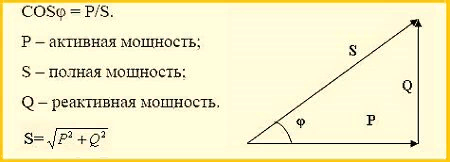

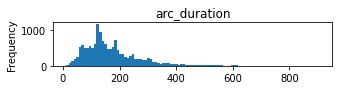

In [10]:
column = 'arc_duration'
data_dict[tbl][column].plot(kind='hist', bins=100, figsize=(5,0.8),title=column);

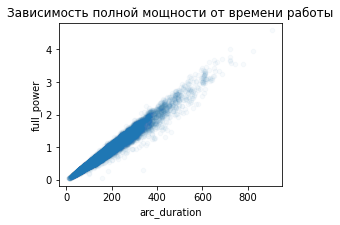

In [11]:
# зависимость мощности от времени
data_dict[tbl].plot(x='arc_duration', 
                    y='full_power', 
                    kind='scatter', 
                    alpha=0.03, 
                    figsize=(4,3),
                    title='Зависимость полной мощности от времени работы'); 

Прямая зависимость между полями full_power и arc_duration. Т.е. в поле full_power - затраты энергии, а не мощность на электродах в единицу времени.

Партия с наибольшим кол-м нагревов: key
2108    16
Name: key, dtype: int64


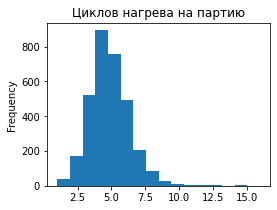

In [12]:
data_dict[tbl].groupby(by='key')['key'].count().plot(kind='hist', 
                                                     bins=16, 
                                                     figsize=(4,3),
                                                     title='Циклов нагрева на партию');

print('Партия с наибольшим кол-м нагревов:', 
      data_dict[tbl].groupby(by='key')['key'].count().sort_values().tail(1))

На 1 партию может быть сделано от 1 до 16 циклов нагрева, но в основном делается от 3 до 6.

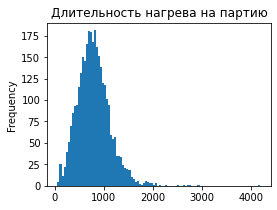

In [13]:
data_dict[tbl].groupby(by='key')['arc_duration'].sum().plot(kind='hist', 
                                                            bins=100, 
                                                            figsize=(4,3),
                                                            title='Длительность нагрева на партию');

**Промежуточный вывод по таблице**
- Форматы данных времени не соответсвуют значениям - **преобразовали в datetime**
- Наблюдается выброс в поле `Реактивная мощность`. **Заменим на медианное значение все, что меньше 0**.
- Пропуска отсутствуют.
- Добавлены **дополнительные вычисляемые поля** - длительность работы в секундах и полная затраченная мощность.
- На 1 партию в среднем приходится 4,63 записи, что соответствует процессу, т.к. каждая запись - нагрев расплава электродами. Есть партии с 1 нагревом, есть и с 16.

---
<span style="color:blue">  
    
#### Таблица `data_bulk` 

Данные о подаче сыпучих материалов (объём)

 
Первые строки таблицы: 


,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,key,table_name
0,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,1,data_bulk
1,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,2,data_bulk
2,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,3,data_bulk


 
Форматы данных: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Bulk 1      252 non-null    float32
 1   Bulk 2      22 non-null     float32
 2   Bulk 3      1298 non-null   float32
 3   Bulk 4      1014 non-null   float32
 4   Bulk 5      77 non-null     float32
 5   Bulk 6      576 non-null    float32
 6   Bulk 7      25 non-null     float32
 7   Bulk 8      1 non-null      float32
 8   Bulk 9      19 non-null     float32
 9   Bulk 10     176 non-null    float32
 10  Bulk 11     177 non-null    float32
 11  Bulk 12     2450 non-null   float32
 12  Bulk 13     18 non-null     float32
 13  Bulk 14     2806 non-null   float32
 14  Bulk 15     2248 non-null   float32
 15  key         3129 non-null   int64  
 16  table_name  3129 non-null   object 
dtypes: float32(15), int64(1), object(1)
memory usage: 232.4+ KB
None

 
Describe числовых данн

,count,mean,std,min,25%,50%,75%,max
Bulk 1,252.0,39.242062,18.277655,10.0,27.00,31.0,46.00,185.0
Bulk 2,22.0,253.045456,21.180578,228.0,242.00,251.5,257.75,325.0
Bulk 3,1298.0,113.879044,75.483490,6.0,58.00,97.5,152.00,454.0
Bulk 4,1014.0,104.394478,48.184124,12.0,72.00,102.0,133.00,281.0
Bulk 5,77.0,107.025970,81.790649,11.0,70.00,86.0,132.00,603.0
Bulk 6,576.0,118.925346,72.057777,17.0,69.75,100.0,157.00,503.0
Bulk 7,25.0,305.600006,191.022903,47.0,155.00,298.0,406.00,772.0
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
Bulk 9,19.0,76.315788,21.720581,63.0,66.00,68.0,70.50,147.0
Bulk 10,176.0,83.284088,26.060347,24.0,64.00,86.5,102.00,159.0


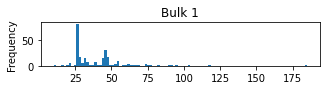

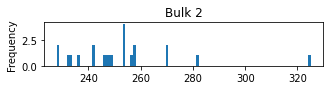

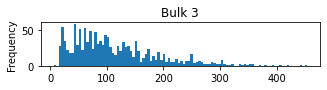

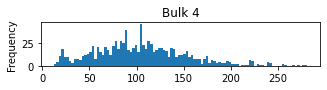

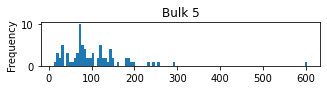

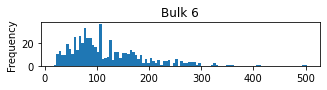

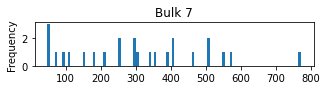

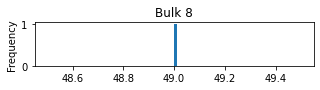

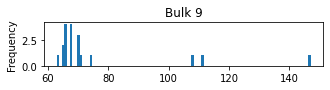

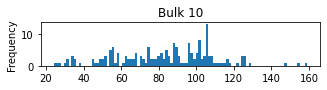

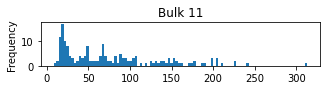

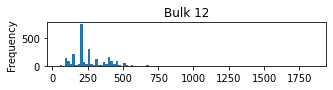

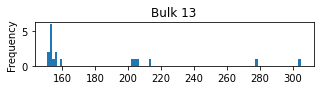

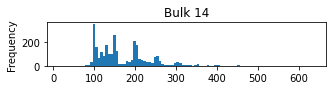

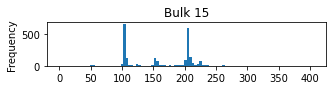


Прочая информация: 
Уникальных партий: 3129
Среднее количество записей на 1 партию: 1.0
Дубликатов: 0
Пропусков:

Bulk 1        2877
Bulk 2        3107
Bulk 3        1831
Bulk 4        2115
Bulk 5        3052
Bulk 6        2553
Bulk 7        3104
Bulk 8        3128
Bulk 9        3110
Bulk 10       2953
Bulk 11       2952
Bulk 12        679
Bulk 13       3111
Bulk 14        323
Bulk 15        881
key              0
table_name       0
dtype: int64


In [14]:
tbl = 'data_bulk'
describe_table(data_dict[tbl])

In [15]:
# заменим пропуски на 0
data_dict[tbl].fillna(0, inplace=True)

**Промежуточный вывод по таблице**
- Форматы данных соответствуют значениям
- Выбросов не наблюдается
- Пропуска есть в значительном количестве, однако это связано с физикой процесса. Каждый столбец bulk соответсвует тому или иному бункеру с определенным материалом. В зависимости от химического анализа расплава, подсыпаются те или иные вещества из соответствующего бункера. Соответственно пропуски равны нулевой подаче материала. **Все пропуски заменены на 0**. 
- На 1 партию приходится 1 запись. Получается, на каждую партию сыпучий материал добавляется только единожды, либо таблица отражает суммарное количество насыпанных материалов за несколько подходов. **Этот вопрос следует уточнить у заказчика.**

---
<span style="color:blue">  
    
#### Таблица `data_bulk_time` 

Данные о подаче сыпучих материалов (время)

In [16]:
tbl = 'data_bulk_time'
describe_table(data_dict[tbl])

 
Первые строки таблицы: 


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,table_name
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52,data_bulk_time
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20,data_bulk_time
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40,data_bulk_time


 
Форматы данных: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   key         3129 non-null   int64 
 1   Bulk 1      252 non-null    object
 2   Bulk 2      22 non-null     object
 3   Bulk 3      1298 non-null   object
 4   Bulk 4      1014 non-null   object
 5   Bulk 5      77 non-null     object
 6   Bulk 6      576 non-null    object
 7   Bulk 7      25 non-null     object
 8   Bulk 8      1 non-null      object
 9   Bulk 9      19 non-null     object
 10  Bulk 10     176 non-null    object
 11  Bulk 11     177 non-null    object
 12  Bulk 12     2450 non-null   object
 13  Bulk 13     18 non-null     object
 14  Bulk 14     2806 non-null   object
 15  Bulk 15     2248 non-null   object
 16  table_name  3129 non-null   object
dtypes: int64(1), object(16)
memory usage: 415.7+ KB
None

 
Describe числовых данных таблицы: 


,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.0,1622.0,2431.0,3241.0



Прочая информация: 
Уникальных партий: 3129
Среднее количество записей на 1 партию: 1.0
Дубликатов: 0
Пропусков:

key              0
Bulk 1        2877
Bulk 2        3107
Bulk 3        1831
Bulk 4        2115
Bulk 5        3052
Bulk 6        2553
Bulk 7        3104
Bulk 8        3128
Bulk 9        3110
Bulk 10       2953
Bulk 11       2952
Bulk 12        679
Bulk 13       3111
Bulk 14        323
Bulk 15        881
table_name       0
dtype: int64


In [17]:
# приведем формат времени к datetime
for i in range(15):
    column_name = f'Bulk {i+1}'
    data_dict[tbl][column_name] = pd.to_datetime(data_dict[tbl][column_name])

**Промежуточный вывод по таблице**
- Форматы данных **приведен к datetime**
- Пропуска есть в значительном количестве, однако это связано с физикой процесса. Каждый столбец bulk соответсвует тому или иному бункеру с определенным материалом. В зависимости от химического анализа расплава, подсыпаются те или иные вещества из соответствующего бункера. Соответственно пропуски равны нулевой подаче материала. Поскольку поля в формате дат, пропуска оставим как есть.
- На 1 партию в среднем приходится 1 запись. Получается, на каждую партию сыпучий материал добавляется только единожды, либо таблица отражает суммарное количество насыпанных материалов за несколько подходов. **Этот вопрос следует уточнить у заказчика.**

---
<span style="color:blue">  
    
#### Таблица `data_wire`

Данные о проволочных материалах (объём)

 
Первые строки таблицы: 


,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,key,table_name
0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,data_wire
1,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,data_wire
2,91.160156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,data_wire


 
Форматы данных: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Wire 1      3055 non-null   float32
 1   Wire 2      1079 non-null   float32
 2   Wire 3      63 non-null     float32
 3   Wire 4      14 non-null     float32
 4   Wire 5      1 non-null      float32
 5   Wire 6      73 non-null     float32
 6   Wire 7      11 non-null     float32
 7   Wire 8      19 non-null     float32
 8   Wire 9      29 non-null     float32
 9   key         3081 non-null   int64  
 10  table_name  3081 non-null   object 
dtypes: float32(9), int64(1), object(1)
memory usage: 156.6+ KB
None

 
Describe числовых данных таблицы: 


,count,mean,std,min,25%,50%,75%,max
Wire 1,3055.0,100.895844,42.012516,1.918800,72.115685,100.158234,126.060486,330.314423
Wire 2,1079.0,50.577320,39.320217,0.030160,20.193680,40.142956,70.227554,282.780151
Wire 3,63.0,189.482666,99.513443,0.144144,95.135040,235.194977,276.252014,385.008667
Wire 4,14.0,57.442848,28.824667,24.148802,40.807003,45.234283,76.124619,113.231041
Wire 5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
Wire 6,73.0,48.016972,33.919842,0.034320,25.053600,42.076324,64.212723,180.454575
Wire 7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847675
Wire 8,19.0,53.625195,16.881727,45.076721,46.094879,46.279999,48.089603,102.762398
Wire 9,29.0,34.155750,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000


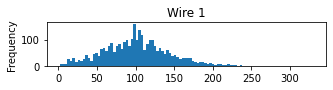

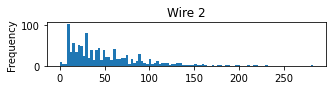

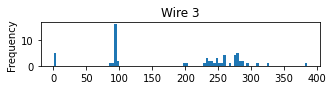

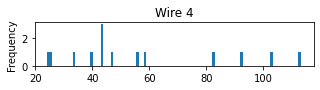

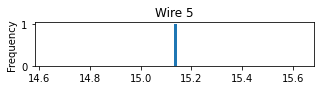

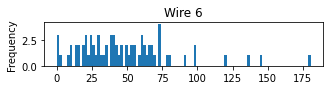

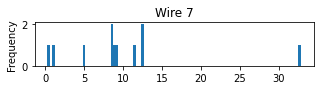

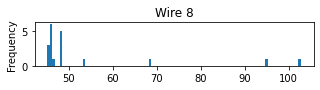

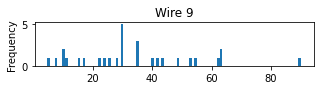


Прочая информация: 
Уникальных партий: 3081
Среднее количество записей на 1 партию: 1.0
Дубликатов: 0
Пропусков:

Wire 1          26
Wire 2        2002
Wire 3        3018
Wire 4        3067
Wire 5        3080
Wire 6        3008
Wire 7        3070
Wire 8        3062
Wire 9        3052
key              0
table_name       0
dtype: int64


In [18]:
tbl = 'data_wire'
describe_table(data_dict[tbl])

In [19]:
# заменим пропуски на 0
data_dict[tbl].fillna(0, inplace=True)

- Форматы данных соответствуют значениям
- Выбросов не наблюдается
- Пропуска есть в значительном количестве, однако это связано с физикой процесса. По аналогии с data_bulk **заменили все пропуски на 0**. 
- На 1 партию в среднем приходится 1 запись. Аналогично таблице с сыпучими материалами.

---
<span style="color:blue">  
    
#### Таблица `data_wire_time`

Данные о проволочных материалах (время).

In [20]:
tbl = 'data_wire_time'
describe_table(data_dict[tbl])

 
Первые строки таблицы: 


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,table_name
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,data_wire_time
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,data_wire_time
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,data_wire_time


 
Форматы данных: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   key         3081 non-null   int64 
 1   Wire 1      3055 non-null   object
 2   Wire 2      1079 non-null   object
 3   Wire 3      63 non-null     object
 4   Wire 4      14 non-null     object
 5   Wire 5      1 non-null      object
 6   Wire 6      73 non-null     object
 7   Wire 7      11 non-null     object
 8   Wire 8      19 non-null     object
 9   Wire 9      29 non-null     object
 10  table_name  3081 non-null   object
dtypes: int64(1), object(10)
memory usage: 264.9+ KB
None

 
Describe числовых данных таблицы: 


,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.0,823.0,1619.0,2434.0,3241.0



Прочая информация: 
Уникальных партий: 3081
Среднее количество записей на 1 партию: 1.0
Дубликатов: 0
Пропусков:

key              0
Wire 1          26
Wire 2        2002
Wire 3        3018
Wire 4        3067
Wire 5        3080
Wire 6        3008
Wire 7        3070
Wire 8        3062
Wire 9        3052
table_name       0
dtype: int64


In [21]:
# приведем формат времени к datetime
for i in range(9):
    column_name = f'Wire {i+1}'
    data_dict[tbl][column_name] = pd.to_datetime(data_dict[tbl][column_name])

**Промежуточный вывод по таблице**
- Форматы данных соответствуют значениям (везде время)
- Выбросов не наблюдается
- Пропуска есть в значительном количестве, однако это связано с физикой процесса. По аналогии с data_bulk_time пропуска оставим как есть.
- На 1 партию в среднем приходится 1 запись. Аналогично таблице с сыпучими материалами.

---
<span style="color:blue">  
    
#### Таблица `data_gas`

Данные о продувке сплава газом

 
Первые строки таблицы: 


,Газ 1,key,table_name
0,29.749987,1,data_gas
1,12.555561,2,data_gas
2,28.554792,3,data_gas


 
Форматы данных: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Газ 1       3239 non-null   float32
 1   key         3239 non-null   int64  
 2   table_name  3239 non-null   object 
dtypes: float32(1), int64(1), object(1)
memory usage: 63.4+ KB
None

 
Describe числовых данных таблицы: 


,count,mean,std,min,25%,50%,75%,max
Газ 1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769916,77.995041
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.000000


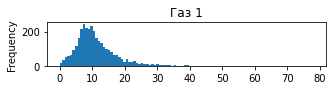


Прочая информация: 
Уникальных партий: 3239
Среднее количество записей на 1 партию: 1.0
Дубликатов: 0
Пропусков:

Газ 1         0
key           0
table_name    0
dtype: int64


In [22]:
tbl = 'data_gas'
describe_table(data_dict[tbl])

**Промежуточный вывод по таблице**
- Форматы данных соответствуют значениям
- Пропуска отсутствуют
- На 1 партию приходится 1 запись. В описании процесса сказано, что операция продувки и перемешивания может проводиться несколько раз. Необходимо уточнить у заказчика.

---
<span style="color:blue">  
    
#### Таблица `data_temp` 

Результаты измерения температуры;

 
Первые строки таблицы: 


,Температура,key,Время замера,table_name
0,1571.0,1,2019-05-03 11:16:18,data_temp
1,1604.0,1,2019-05-03 11:25:53,data_temp
2,1618.0,1,2019-05-03 11:29:11,data_temp


 
Форматы данных: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Температура   13006 non-null  float32
 1   key           15907 non-null  int64  
 2   Время замера  15907 non-null  object 
 3   table_name    15907 non-null  object 
dtypes: float32(1), int64(1), object(2)
memory usage: 435.1+ KB
None

 
Describe числовых данных таблицы: 


,count,mean,std,min,25%,50%,75%,max
Температура,13006.0,1591.840942,21.375851,1191.0,1581.0,1591.0,1601.0,1705.0
key,15907.0,1607.880870,942.212073,1.0,790.0,1618.0,2427.0,3241.0


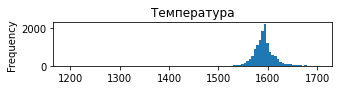


Прочая информация: 
Уникальных партий: 3216
Среднее количество записей на 1 партию: 4.95
Дубликатов: 0
Пропусков:

Температура     2901
key                0
Время замера       0
table_name         0
dtype: int64


In [23]:
tbl = 'data_temp'
describe_table(data_dict[tbl])

In [24]:
# приведем формат времени к datetime
data_dict[tbl]['Время замера'] = pd.to_datetime(data_dict[tbl]['Время замера'])

In [25]:
# проверим номера партий с пропуском температуры
key_without_temp = data_dict[tbl].loc[data_dict[tbl]['Температура'].isna()]['key'].to_list()
key_without_temp = set(key_without_temp)
print('Номеров партий с пропусками замеров температур:', len(key_without_temp))
data_dict[tbl].query('key in @key_without_temp').head(20)

Номеров партий с пропусками замеров температур: 739


,Температура,key,Время замера,table_name
12267,1539.0,2500,2019-08-06 03:11:31,data_temp
12268,NaN,2500,2019-08-06 03:24:43,data_temp
12269,NaN,2500,2019-08-06 03:25:16,data_temp
12270,NaN,2500,2019-08-06 03:28:21,data_temp
12271,1587.0,2501,2019-08-06 03:44:42,data_temp
12272,NaN,2501,2019-08-06 04:01:59,data_temp
12273,NaN,2501,2019-08-06 04:14:35,data_temp
12274,NaN,2501,2019-08-06 04:22:14,data_temp
12275,NaN,2501,2019-08-06 04:31:14,data_temp
12276,1583.0,2502,2019-08-06 04:45:26,data_temp


Есть 739 партий с отсутствующими замерами температуры, есть только значение первого замера. Такие партии с неполными данными по температуре на подходят для моделирования, потому удалим их из всех таблиц датасета.

In [26]:
# удалим партии из списка key_without_temp
for key, _ in data_dict.items():
    print('Записей в', key, 'до:', len(data_dict[key]), end='')
    data_dict[key] = data_dict[key].query('key not in @key_without_temp')
    print(' после:', len(data_dict[key]))

Записей в data_arc до: 14876 после: 11449
Записей в data_bulk до: 3129 после: 2408
Записей в data_bulk_time до: 3129 после: 2408
Записей в data_gas до: 3239 после: 2500
Записей в data_temp до: 15907 после: 12267
Записей в data_wire до: 3081 после: 2373
Записей в data_wire_time до: 3081 после: 2373


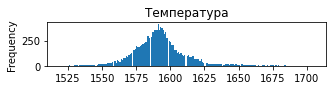

In [27]:
# скорректируем выбросы медианным значением
column = 'Температура'
data_dict[tbl].loc[data_dict[tbl][column]<1420, column] = data_dict[tbl][column].median()
data_dict[tbl][column].plot(kind='hist', bins=200, figsize=(5,0.8),title=column);

**Промежуточный вывод по таблице**
- Форматы данных времени **приведен к datetime**
- Наблюдается выброс в поле `Температура`, т.к. тепература плавления стали начинается от 1420 градусов. **Заменили на медианное значение все, что меньше 1420**.
- На 1 партию в среднем приходится 4,95 записи, что превышает даже значения запуска нагрева (таблица data_arc, 4.63 записи/партию). Таким образом, температура замеряется чаще, чем производится нагрев. 
- Есть 2901 пропуск, распределенный по 739 партиям с пропусками замеров температуры, кроме первого замера. **Такие партии удалены из всех таблиц датасета.**
- Из данной таблицы в дальнешем можно использовать последний замер температуры по партии как **целевой признак**. Значение первого замера может быть использовано как **один из входящих параметров**

### Исследование сочетаемости таблиц

#### Сочетаемость номеров партий

Всего уникальных партий: 2502


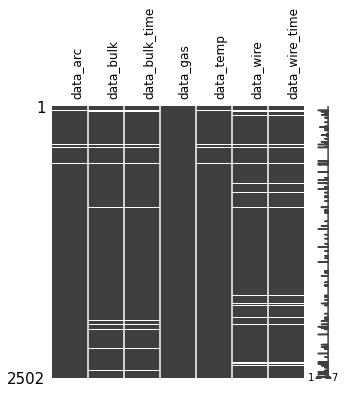

In [28]:
df_batches = None
for key, value in data_dict.items():
    if df_batches is None:
        df_batches = value[['key', 'table_name']].reset_index()
    else:
        df_batches = pd.concat([df_batches, 
                                value[['key', 'table_name']].reset_index()])
    
print('Всего уникальных партий:', df_batches['key'].nunique()) 

try:
    missingno.matrix(df_batches.pivot_table(index=['key'], columns='table_name', values='key', aggfunc='count'),
                     figsize=(5,5), 
                     fontsize=12, 
                     label_rotation=90);
except:
    pass

В датасете осталась 2502 уникальная партия, при этом видно, что:
- в некоторых случаях в партию не подмешивались никакие компоненты (пропуски в data_bulk, data_wire). Партия только нагревалася и продувалась газом.
- пропуски в парах data_bulk+data_bulk_time и data_wire+data_wire_time идут синхронно, что правильно
- Для небольшого количества партий отсутствуют замеры температуры. **Такие партии не попадут в объединенный датасет.**


#### Сочетаемость времени отработки процессов

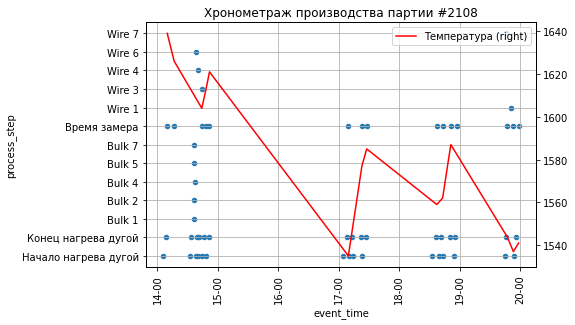

,key,table_name,process_step,event_time
0,2108,data_arc,Начало нагрева дугой,2019-07-23 14:05:57
36,2108,data_arc,Конец нагрева дугой,2019-07-23 14:08:12
271,2108,data_temp,Время замера,2019-07-23 14:09:40
272,2108,data_temp,Время замера,2019-07-23 14:16:34
1,2108,data_arc,Начало нагрева дугой,2019-07-23 14:32:08
37,2108,data_arc,Конец нагрева дугой,2019-07-23 14:33:35
125,2108,data_bulk_time,Bulk 2,2019-07-23 14:35:55
89,2108,data_bulk_time,Bulk 1,2019-07-23 14:35:55
233,2108,data_bulk_time,Bulk 7,2019-07-23 14:35:55
197,2108,data_bulk_time,Bulk 5,2019-07-23 14:35:55


In [29]:
# отобразим историю отработки процесса для партии с самым большим количеством нагревов, мы нашли ее ранее
batch_num = 2108

df_batch_timings = None

# соберем все данные со временем в 1 большую таблицу df_batch_timings
for key, value in data_dict.items():
    if df_batch_timings is None:
        df_batch_timings = value.select_dtypes(include='datetime')
        df_batch_timings[['key', 'table_name']] = value[['key', 'table_name']]
    else:
        add = value.select_dtypes(include='datetime')
        add[['key', 'table_name']] = value[['key', 'table_name']]
        df_batch_timings = pd.concat([df_batch_timings, add])

# фильтруем только события для искомой партии
sample = df_batch_timings[df_batch_timings['key'] == batch_num] 
sample = sample.dropna(axis=1, how='all')

# из широкой таблицы сделаем длинную
sample = pd.melt(sample, 
                id_vars=['key', 'table_name'],  
                value_vars=sample.columns, 
                var_name='process_step', 
                value_name='event_time').dropna()

# отобразим на графике время отработки процессов
ax = sample.plot(kind='scatter', 
            x='event_time', 
            y='process_step', 
            figsize=(7,5), 
            grid=True,  
            rot=90, secondary_y=False);
time_form = mpl.dates.DateFormatter("%H-%M")
ax.xaxis.set_major_formatter(time_form)

# получим данные замера температур для отдельного графика
# график построим по второстепенной оси
sample_temp = data_dict.get('data_temp').query('key == @batch_num') 

ax1 = ax.twinx()
sample_temp.plot(kind='line', x='Время замера', 
            y='Температура', ax=ax1, secondary_y=True, color='r')
plt.title(f'Хронометраж производства партии #{batch_num}' )
plt.show()

# отобразим данные списком
display(sample.sort_values(by='event_time'))

На примере этой партии видно, что события в разных таблицах по времени сочетаются, т.к. события выстроены в логичную последовательность согласно процессу получения стали. Никаких дополнительных операций по синхронизаци времени в разных таблицах делать не требуется.

### Исследование объединенного датасета

#### Объединение в общую таблицу

На предыдущих этапах мы проверили, что данные в разных таблицах сочетаются по номерам партий и по времени отработки. Теперь необходимо объединить все таблицы в единый массив данных. Порскольку объектом моделирования будет являться 1 партия (1 ковш), объединять будем по номеру партии `key`. Объединение проведем по следующему алгоритму:
1. `data_temp` — сгруппируем по номеру партии, присоединим температуру на первом и последнем замере (целевой признак)
2. `data_arc` — присоединим по номеру партии полную мощность и суммарное время работы электродов
3. `data_bulk` — по номеру партии присоединим расход сыпучих материалов
4. `data_wire` — по номеру партии присоединим расход проволочных материалов
5. `data_gas` — по номеру партии присоединим расход газа на продувку сплава

Данные из `data_wire_time` и `data_bulk_time` содержат время добавления присадок, в рамках данной модели добавлять их в датасет не будем

In [30]:
data_dict['data_arc'][data_dict['data_arc']['key']==1]

,Активная мощность,Реактивная мощность,key,Начало нагрева дугой,Конец нагрева дугой,table_name,arc_duration,full_power
0,0.976059,0.687084,1,2019-05-03 11:02:14,2019-05-03 11:06:02,data_arc,228,1.193639
1,0.805607,0.520285,1,2019-05-03 11:07:28,2019-05-03 11:10:33,data_arc,185,0.959010
2,0.744363,0.498805,1,2019-05-03 11:11:44,2019-05-03 11:14:36,data_arc,172,0.896038
3,1.659363,1.062669,1,2019-05-03 11:18:14,2019-05-03 11:24:19,data_arc,365,1.970470
4,0.692755,0.414397,1,2019-05-03 11:26:09,2019-05-03 11:28:37,data_arc,148,0.807239


In [31]:
# ШАГ 1 - сгруппируем по партии и подтянем стартовую и конечную температуры
finish_temp = (data_dict['data_temp']
               .sort_values('Время замера')
               .groupby(['key'])
               .tail(1)
               .reset_index()[['key','Температура']]
               .rename(columns={'Температура': 'finish_temp'}))

start_temp = (data_dict['data_temp']
              .sort_values('Время замера')
              .groupby(['key'])
              .head(1)
              .reset_index()[['key','Температура']]
              .rename(columns={'Температура': 'start_temp'}))

data = start_temp.merge(finish_temp, on='key', how='inner')

In [32]:
# ШАГ 2 - присоединим полную мущность и время работы электродов
arc_summarized = (data_dict['data_arc']
                  .groupby(['key'])
                  .sum()[['arc_duration','full_power']]
                  .reset_index())

data = data.merge(arc_summarized, on='key', how='inner')

In [33]:
# ШАГ 3 - присоединим расход сыпучих материалов
data = data.merge(data_dict['data_bulk'], on='key', how='inner')
data.drop('table_name', axis=1, inplace=True)

In [34]:
# ШАГ 4 - присоединим расход проволоки
data = data.merge(data_dict['data_wire'], on='key', how='inner')
data.drop('table_name', axis=1, inplace=True)

In [35]:
# ШАГ 5 - присоединим расход газа
data = data.merge(data_dict['data_gas'], on='key', how='inner')
data.drop('table_name', axis=1, inplace=True)

In [36]:
data.set_index('key', inplace=True)

Проверим, что получилось

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   start_temp    2329 non-null   float32
 1   finish_temp   2329 non-null   float32
 2   arc_duration  2329 non-null   int64  
 3   full_power    2329 non-null   float32
 4   Bulk 1        2329 non-null   float32
 5   Bulk 2        2329 non-null   float32
 6   Bulk 3        2329 non-null   float32
 7   Bulk 4        2329 non-null   float32
 8   Bulk 5        2329 non-null   float32
 9   Bulk 6        2329 non-null   float32
 10  Bulk 7        2329 non-null   float32
 11  Bulk 8        2329 non-null   float32
 12  Bulk 9        2329 non-null   float32
 13  Bulk 10       2329 non-null   float32
 14  Bulk 11       2329 non-null   float32
 15  Bulk 12       2329 non-null   float32
 16  Bulk 13       2329 non-null   float32
 17  Bulk 14       2329 non-null   float32
 18  Bulk 15       2329 non-null 

**Промежуточный вывод**
- Сформирован единый датасет по 2329 уникальным партиям.
- Каждая партия содержит признаки, целевой параметр (`finish_temp`)

#### Анализ объединенного датасета


**Ненулевые значения факторов**

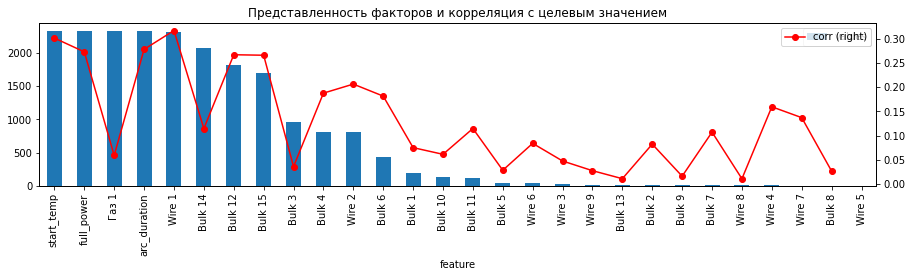

In [38]:
# количесво ненулевых значений факторов
df = data>0
df = df.sum().reset_index()
df.columns = ['feature', 'values']
df = df.sort_values(by='values', ascending=False)
df = df[df['feature']!='finish_temp']

# abs(корреляции) факторов к целевому признаку 
corr = data.corr()['finish_temp'].abs().reset_index()
corr.columns = ['feature', 'corr']
corr = corr[corr['feature']!='finish_temp']

df = df.merge(corr, on='feature')

# график
ax = df.plot(x ='feature',
             y='values',
             kind='bar', 
             figsize=(15,3))

ax1=ax.twinx()

ax = df.plot(kind='line', 
             x ='feature', 
             y='corr',
             marker='o',   
             secondary_y=True, 
             ax=ax1, 
             color='r')

plt.title(f'Представленность факторов и корреляция с целевым значением' )
plt.show()  

Среди признаков выделяются очень редко встречающиеся признаки. Однако при этом их влияние на итоговый результат может коррелировать с итоговым результатом на уровне очень часто встречающихся признаков.

Также, некоторые признаки, хоть и редкие, могут характеризовать особый тип сплава, резко отличающийся по температуре от других сортов. **Проверим распределение температуры для разных признаков Bulk и Wire**

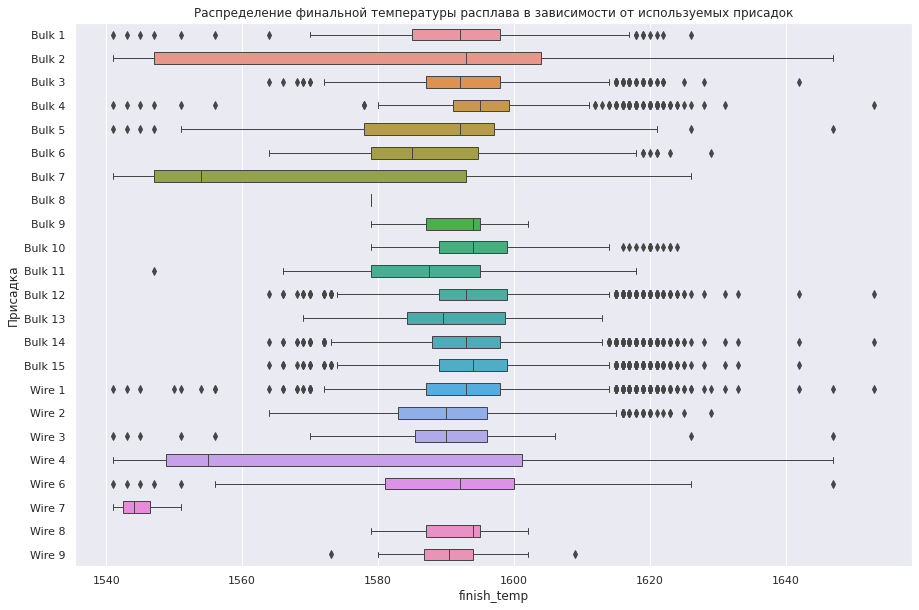

In [39]:
# названия колонок с признаками Bulk и Wire
bulk_col = [k for k in data.columns if 'Bulk' in k]
wire_col = [k for k in data.columns if 'Wire' in k]

# собираем данные по final_temp для каждой партии с добавлением той или иной сыпучей присадки
data_graph = None
for bulk in bulk_col+wire_col:
    if data_graph is None:
        data_graph = pd.DataFrame(data.loc[data[bulk]>0]['finish_temp'])
        data_graph['Присадка'] = bulk
    else:
        add = pd.DataFrame(data.loc[data[bulk]>0]['finish_temp'])
        add['Присадка'] = bulk
        data_graph = pd.concat([data_graph, add])
'''
# собираем данные по final_temp для каждой партии с добавлением той или иной сыпучей присадки
for wire in wire_col:
    if data_graph is None:
        data_graph = pd.DataFrame(data.loc[data[wire]>0]['finish_temp'])
        data_graph['Присадка'] = wire
    else:
        add = pd.DataFrame(data.loc[data[wire]>0]['finish_temp'])
        add['Присадка'] = wire
        data_graph = pd.concat([data_graph, add])
'''
# отобразим распределение температур для разных присадок
sns.set(rc={'figure.figsize':(15,10)}) # установим размер графиков 
ax = sns.boxplot(y='Присадка', 
                 x='finish_temp', 
                 data=data_graph, 
                 width=0.5,  
                 linewidth=1, 
                 orient="h",  )
ax.set_title('Распределение финальной температуры расплава в зависимости от используемых присадок');

**Промежуточный вывод**

Как видим - большинство присадок используется в сплавах с температурой выхода в диапазоне 1580-1600 градусов. Однако, использование ряда присадок (`Bulk 2`, `Bulk 7`, `Wire 4`), приводит к значительно меньшим температурам выхода. При этом частота выплавки партий с такими присадками небольшая. Из всего вышеозвученного можно сделать вывод, что малоприменяемые присадки не стоит приводить к одной категории, например Bulk_other и Wire_other - это снизит точность модели и отдалит от целевого MAE<=6.8. Партии с **редкими признаками будем масштабировать**

#### Проверка на мультиколлинеарность

Прежде, чем передавать датасет в модели машинного обучения, необходимо проверить признаки на мультиколлинеарность.

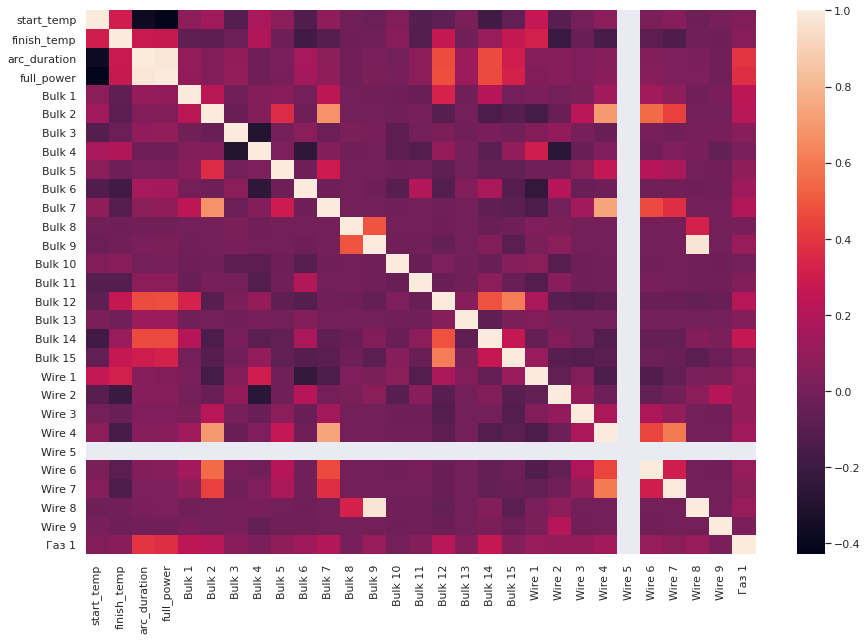

In [40]:
# проверим признаки на мультиколлинеарность
fig, ax = plt.subplots(figsize=(15,10))  
sns.heatmap(data.corr(), ax=ax);

На температурной карте видны следующие аномалии:
- высокая корреляция между `full_power` и `arc_duration`
- высокая корреляция между `Wire 8` и `Bulk 9`
- невозможность установить корреляцию для `Wire 5`

Удалим следующие признаки: `arc_duration`, `Wire 8`, `Wire 5`

In [41]:
data = data.drop(columns=['arc_duration', 'Wire 8', 'Wire 5'], axis=1)

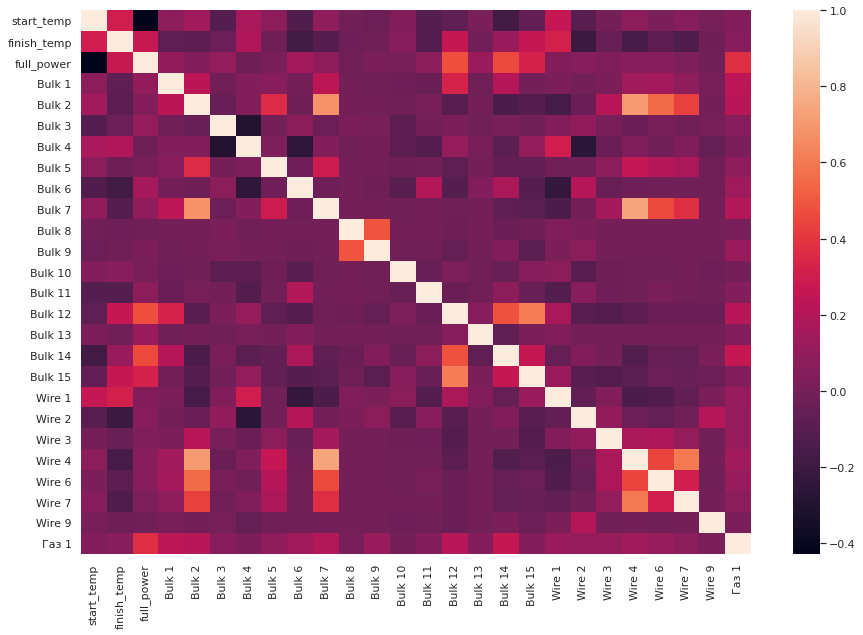

In [42]:
# проверим признаки на мультиколлинеарность
fig, ax = plt.subplots(figsize=(15,10))  
sns.heatmap(data.corr(), ax=ax);

### Промежуточный вывод

**Импорт исходных данных**
- Данные в целом предоставлены в хорошем качестве, все таблицы в едином формате, хорошо структурированы, импортируются без проблем
- Во время импорта принудительно сокращена разрядность float значений до float32
- Все данные даты/времени приведены к формату datetime

**Качество данных отдельных таблиц**
- Пропуски в данных встречаются в трех случаях:
    - таблицы data_bulk, data_wire - пропуски оправданы отсутствием подачи того или иного материала. Заменены на 0
    - таблицы data_bulk_time, data_wire_time - пропуски оправданы отсутствием подачи того или иного материала, оставлены как есть
    - таблица data_temp - есть много пропусков в поле Температура, партии с такими пропусками полностью удалены их всех таблиц.
- Дубликаты данных отсутствуют
- Данные в таблицах data_arc, data_temp, data_gas по распределению близки к нормальному, но с уклоном вправо.
- Выбросы в данных практически отсутствуют. В некоторых таблицах распределение величин (длительность работы дуги, затраты мощности, расход газа и т.д.) имеет смещение вправо, в т.ч. со зачительными отклоенениями от медианы, но принято решение оставить их в модели, т.к. точечное удаление данных из отдельных таблиц повредит общей картине.

**Согласованность данных между таблицами**
- Номера партий металла согласованы между разными таблицами. В целом мы говорим о наличии упоминаний по 3241 партиям металла, с учетом удаления партий с неполными параметрами температур, для дальнейшего анализа осталось 2502 партий.
- Время отработки технологических операций также согласовано между таблицами и порядок их исполнения укладывается в описание тахнологического процесса из вводных данных.

**Объединенная таблица**
- Таблицы были объединены по следующему алгоритму:
    1. `data_temp` — сгруппируем по номеру партии, присоединим температуру на первом и последнем замере (целевой признак)
    2. `data_arc` — присоединим по номеру партии полную мощность и суммарное время работы электродов
    3. `data_bulk` — по номеру партии присоединим расход сыпучих материалов
    4. `data_wire` — по номеру партии присоединим расход проволочных материалов
    5. `data_gas` — по номеру партии присоединим расход газа на продувку сплава

- После слияния таблиц часть данных также не состыковалась и в итоге осталось 2329 уникальных партии
- Каждая партия содержит признаки, целевой параметр (`finish_temp`)
- Проведена проверка влияния редких признаков на финальную температуру расплава - замечено, что некоторые редкие признаки в значительной мере влияют на температуру. Таким образом необходимо будет масштабировать записи с редкими признаками в тренировочной выборке для достижения более точного результата.
- Проведена проверка на мультиколлинеарность, признаки `arc_duration`, `Wire 8`, `Wire 5` удалены

## Построение модели машинного обучения

### Подготовка выборок

In [43]:
RANDOM_STATE = 130223 

In [44]:
data

,start_temp,finish_temp,full_power,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 9,Газ 1
key,,,,,,,,,,,,,,,,,,,,,
1,1571.0,1613.0,5.826395,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,29.749987
2,1581.0,1602.0,3.649216,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,12.555561
3,1596.0,1599.0,2.989534,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,152.0,153.0,91.160156,0.00000,0.0,0.0,0.0,0.0,0.0,28.554792
4,1601.0,1625.0,3.814962,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,18.841219
5,1576.0,1602.0,4.035758,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,151.0,152.0,89.238235,9.11456,0.0,0.0,0.0,0.0,0.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1570.0,1591.0,3.986868,0.0,0.0,21.0,0.0,0.0,0.0,0.0,...,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,7.125735
2496,1554.0,1591.0,5.057033,0.0,0.0,0.0,63.0,0.0,0.0,0.0,...,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,9.412616
2497,1571.0,1589.0,2.885017,0.0,0.0,0.0,85.0,0.0,0.0,0.0,...,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,6.271699


#### Разделение на обучающую и тестовую выборки

In [45]:
# разделим общую таблицу на признаки и целевое значение
features = data.drop(['finish_temp'], axis=1) 
target = data['finish_temp'] 

print('features.shape:', features.shape)
print('target.shape:', target.shape)

features.shape: (2329, 25)
target.shape: (2329,)


In [46]:
# отделим тестовую выборку в 25% от общего размера датасета
x_train, x_test, y_train, y_test= train_test_split(
        features, target, test_size=0.25, random_state=RANDOM_STATE)

print(f'x_train.shape:\t{x_train.shape}\t{round(100*y_train.shape[0]/target.shape[0])}%')
print(f'x_test.shape:\t{x_test.shape}\t{round(100*y_test.shape[0]/target.shape[0])}%')

x_train.shape:	(1746, 25)	75%
x_test.shape:	(583, 25)	25%


---
**Промежуточный вывод:**
- Датасет был разделен на таблицы: `features` из 25 признаков и `target` c 1 целевым значением
- Полученные таблицы в свою очередь разделены на TRAIN / TEST в пропорции  75 / 25

#### Масштабирование признаков

In [47]:
# проведем скалирование числовых признаков
# в нашем случае все признаки - числовые
numeric = x_train.columns

x_scaled_train = x_train.copy()
x_scaled_test = x_test.copy()

scaler = StandardScaler()
scaler.fit(x_train[numeric])
x_scaled_train[numeric] = scaler.transform(x_train[numeric])
x_scaled_test[numeric] = scaler.transform(x_test[numeric])

### Обучение моделей

In [48]:
# словарь для сохранения результатов обучения моделей
models_dict = {}

In [49]:
# функция для отображения графиков влияния параметров
# на метрику в GridSearchCV 
def plot_search_results(grid):
    """
    Source: 
        https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = - results['mean_test_score']
    stds_test = - results['std_test_score']
    #means_train = results['mean_train_score']
    #stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        #y_2 = np.array(means_train[best_index])
        #e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='train')
        #ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

#### Линейная регрессия

In [50]:
%%time
model_linear = LinearRegression()

parameters = {}
grid = GridSearchCV(estimator=model_linear, 
                    param_grid=parameters, 
                    scoring='neg_mean_absolute_error', 
                    cv=5, 
                    verbose=1,
                    n_jobs=-1)

grid.fit(x_scaled_train, y_train)

# получаем лучшие результаты
print("\033[94m\x1B[1m")
print("MAE модели LinearRegression :", round(np.mean(-grid.best_score_),4))
print('\x1b[0m')

models_dict['LinearRegression'] = {'MAE': -grid.best_score_, 
                                   'best_params': grid.best_params_,
                                   'best_model': grid.best_estimator_}

Fitting 5 folds for each of 1 candidates, totalling 5 fits

MAE модели LinearRegression : 6.2938

CPU times: user 99.9 ms, sys: 126 ms, total: 226 ms
Wall time: 145 ms


#### Случайный лес

Fitting 5 folds for each of 20 candidates, totalling 100 fits

MAE модели RandomForestRegressor : 6.1671

Наилучшие параметры: {'max_depth': 10, 'n_estimators': 400}



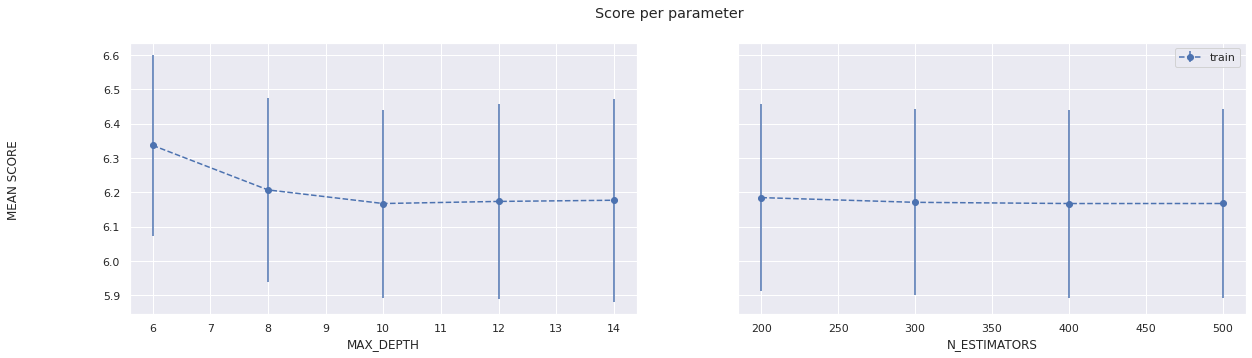

CPU times: user 3min 25s, sys: 993 ms, total: 3min 26s
Wall time: 3min 27s


In [51]:
%%time
model_ranforest = RandomForestRegressor(random_state=RANDOM_STATE)

parameters = {'n_estimators': [200,300,400,500],
             'max_depth': [6,8,10,12,14]}

grid = GridSearchCV(estimator=model_ranforest, 
                    param_grid=parameters, 
                    scoring='neg_mean_absolute_error', 
                    cv=5, 
                    verbose=1,
                    n_jobs=-1)

grid.fit(x_scaled_train, y_train)

# получаем лучшие результаты
print("\033[94m\x1B[1m")
print("MAE модели RandomForestRegressor :", round(np.mean(-grid.best_score_),4))
print('\nНаилучшие параметры:',grid.best_params_)
print('\x1b[0m')

models_dict['RandomForestRegressor'] = {'MAE': -grid.best_score_,  
                                        'best_params': grid.best_params_,
                                        'best_model': grid.best_estimator_}

plot_search_results(grid)

#### Градиентный бустинг с перебором гиперпараметров


MAE модели CatBoostRegressor : 6.0293

Наилучшие параметры: {'depth': 5, 'iterations': 150, 'learning_rate': 0.1}



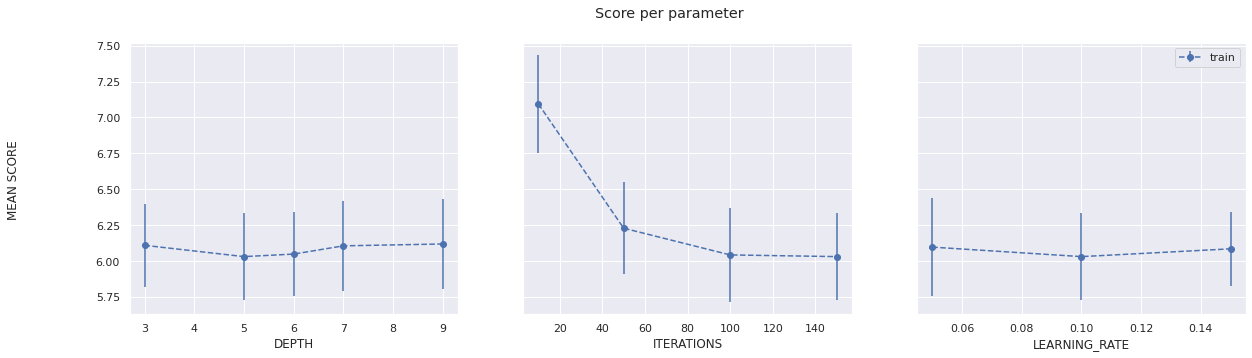

CPU times: user 2min 8s, sys: 3.55 s, total: 2min 12s
Wall time: 4min 23s


In [52]:
%%time
model_catboost = CatBoostRegressor(random_state=RANDOM_STATE, 
                                   verbose=False)

parameters = {'learning_rate': [0.05, 0.1, 0.15], 
              'depth': [3,5,6,7,9], 
              'iterations': [10, 50, 100, 150]}

grid = GridSearchCV(estimator=model_catboost, 
                    param_grid=parameters, 
                    scoring='neg_mean_absolute_error', 
                    cv=5, 
                    verbose=2,
                    n_jobs=-1)

grid.fit(x_scaled_train, y_train)

clear_output()

# получаем лучшие результаты
print("\033[94m\x1B[1m")
print("MAE модели CatBoostRegressor :", round(np.mean(-grid.best_score_),4))
print('\nНаилучшие параметры:',grid.best_params_)
print('\x1b[0m')

models_dict['CatBoostRegressor'] = {'MAE': -grid.best_score_,  
                                'best_params': grid.best_params_, 
                                'best_model': grid.best_estimator_}


plot_search_results(grid)

#### Нейронная сеть

2023-02-20 20:34:03.081710: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0epoch [00:00, ?epoch/s]

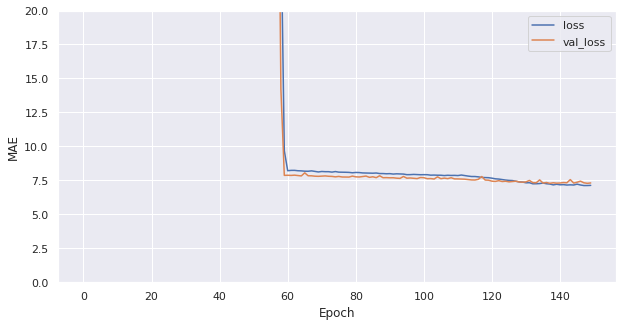

In [53]:
# функция создания модели
def create_model(neurons, learning_rate):
    model = keras.Sequential()
    model.add(layers.Dense(neurons, input_dim=x_train.shape[1], activation='sigmoid'))
    model.add(layers.Dense(1))
 
    model.compile(optimizer=RMSprop(lr=learning_rate),    
                  loss='mean_absolute_error')
    return model

# функция отрисовки графика обучения
def plot_loss(history):
    ax = mpl.pyplot.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 20])
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

# создадим и обучим модель
neurons = 1000
learning_rate = 0.001
epochs = 150
model_keras = create_model(neurons, learning_rate)

history = model_keras.fit(x_train, 
                          y_train, 
                          validation_split=0.2, 
                          epochs=epochs, 
                          verbose=0, 
                          callbacks=[TqdmCallback(verbose=0)])  
# отобразим график обучения
plot_loss(history)

# сохраним получившуюся модель
models_dict['Neural network'] = {'MAE': history.history['val_loss'][-1],  
                                'best_params': {'neurons': neurons,
                                                'learning_rate': learning_rate, 
                                                'epochs': epochs}, 
                                'best_model': model_keras}

#### Константная модель

In [54]:
# создадим DummyRegressor для оценки поведения алгоритма, 
# всегда предсказывающего медианное значение температуры
model_dummy = DummyRegressor(strategy="median")

parameters = {}

grid = GridSearchCV(estimator=model_dummy, 
                    param_grid=parameters, 
                    scoring='neg_mean_absolute_error', 
                    cv=5, 
                    verbose=1,
                    n_jobs=-1)

grid.fit(x_scaled_train, y_train)

# получаем лучшие результаты
print("\033[94m\x1B[1m")
print("MAE модели DummyRegressor :", round(np.mean(-grid.best_score_),4))
print('\nНаилучшие параметры:',grid.best_params_)
print('\x1b[0m')

models_dict['DummyRegressor'] = {'MAE': -grid.best_score_,  
                                'best_params': grid.best_params_, 
                                'best_model': grid.best_estimator_}

Fitting 5 folds for each of 1 candidates, totalling 5 fits

MAE модели DummyRegressor : 8.1057

Наилучшие параметры: {}



#### Выбор лучшей модели

In [55]:
pd.DataFrame(models_dict).T.sort_values(by='MAE')

,MAE,best_params,best_model
CatBoostRegressor,6.029316,"{'depth': 5, 'iterations': 150, 'learning_rate...",<catboost.core.CatBoostRegressor object at 0x7...
RandomForestRegressor,6.167121,"{'max_depth': 10, 'n_estimators': 400}","(DecisionTreeRegressor(max_depth=10, max_featu..."
LinearRegression,6.293831,{},LinearRegression()
Neural network,7.310498,"{'neurons': 1000, 'learning_rate': 0.001, 'epo...",<keras.engine.sequential.Sequential object at ...
DummyRegressor,8.10566,{},DummyRegressor(strategy='median')


По результатам метрики MAE, полученой методом кросс-валидации лидирует модель **CatBoostRegressor с результатом 6.03**

In [56]:

print('Гиперпараметры лучшей модели:', models_dict.get('CatBoostRegressor')['best_params'])

Гиперпараметры лучшей модели: {'depth': 5, 'iterations': 150, 'learning_rate': 0.1}


**Промежуточные выводы:**

- объединенный датасет был разделен на обучающую и тестовую выборки в пропорции 75:25
- признаки были отмасштабированы на основе обучающей выборки
- было обучено 4 модели : 
    - LinearRegression
    - RandomForestRegressor
    - CatBoostRegressor
    - Neural network
- Дополнительно была построена дамми-модель DummyRegressor, которая всегда возвращает медианное значение
- Все обученные модели показывают результат лучше, чем дамми-модель
- **Наилучший MAE показала модель CatBoostRegressor с результатом 6.03**. Ее будем использовать на этапе "Проверка моделей"

### Проверка моделей

#### Тестирование лучшей модели на тестовой выборке

In [57]:
best_model = models_dict.get('CatBoostRegressor')['best_model']

predictions = best_model.predict(x_scaled_test)

print('Метрика MAE лучшей модели на тестовой выборке:', mean_absolute_error(y_test, predictions))

Метрика MAE лучшей модели на тестовой выборке: 6.004288013624056


Метрика на тестовой выборке показала результат 6.00, что соответствует критерию MAE <= 6.8

#### Анализ важности факторов

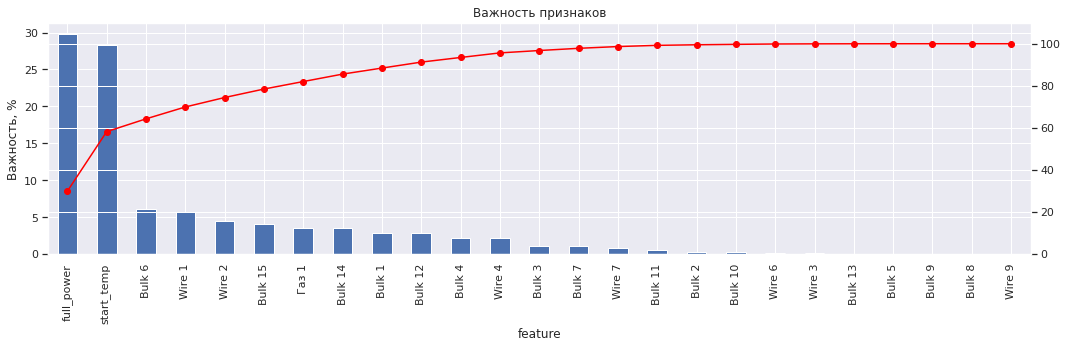

,importance,pareto,is_important
feature,,,
full_power,29.847844,29.847844,True
start_temp,28.331912,58.179756,True
Bulk 6,6.086446,64.266201,True
Wire 1,5.649542,69.915743,True
Wire 2,4.498234,74.413978,True
Bulk 15,4.031414,78.445392,True


In [58]:
# получим важность показателей из обученной модели
features_imp = pd.Series(best_model.get_feature_importance(), x_scaled_train.columns)

# дополним таблицу важности парето анализом и маркером важности переменных
# маркер важности проставляется согласно переменной pareto_cut
pareto_cut=80
features_imp = features_imp.sort_values(ascending=False)
features_imp = pd.DataFrame({'feature':features_imp.index, 
                             'importance':features_imp.values, 
                             'pareto': 0, 
                             'is_important': False}).set_index('feature')

# добавим парето анализ
for i in range(len(features_imp)):
    features_imp.iloc[i, 1] = features_imp.iloc[i, 0] + features_imp.iloc[i-1, 1]
    if features_imp.iloc[i, 1] <= pareto_cut: features_imp.iloc[i, 2] = True

# график
fig, ax = plt.subplots(figsize=(15,5))
features_imp['importance'].plot(kind='bar', ax=ax)
ax1=ax.twinx()
plt.ylim(0, 110)
features_imp['pareto'].plot(kind='line', color='red', marker='o', ax=ax1)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

plt.show()

display(features_imp.loc[features_imp['is_important']])

In [67]:
display(features_imp.index.sort_values())

Index(['Bulk 1', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14',
       'Bulk 15', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7',
       'Bulk 8', 'Bulk 9', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 6',
       'Wire 7', 'Wire 9', 'full_power', 'start_temp', 'Газ 1'],
      dtype='object', name='feature')

#### Анализ остатков

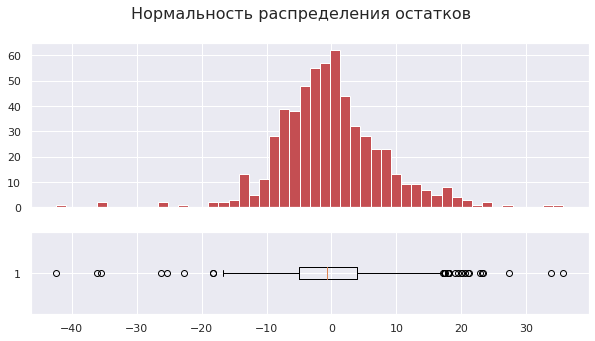

In [68]:
predictions = best_model.predict(x_scaled_test)
residuals = y_test - predictions
residuals = pd.DataFrame({'real': y_test,
                          'prediction': predictions, 
                          'residual': residuals})

# нормальность распредления остатков
fig, (ax1, ax2) = plt.subplots(2, 1, 
                               sharex=True, 
                               figsize=(10,5),  
                               gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle('Нормальность распределения остатков', fontsize=16)
ax1.hist(residuals['residual'], bins=50, color='r')
ax2.boxplot(residuals['residual'], vert=False);


Распределение остатков предсказаний модели близко к нормальному, с незначительным уклоном вправо. То есть модель немного чаще предсказывает температуру ниже реальной. С обеих сторон в единичных случаях наблюдается некоторое количество выбросов.

В целом остатки распределены хорошо.


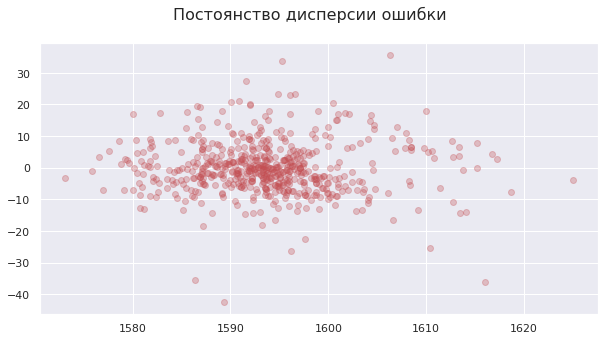

In [69]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Постоянство дисперсии ошибки', fontsize=16)
plt.scatter(x=residuals['prediction'], 
            y=residuals['residual'], 
            color='r', alpha=0.3);


На графике не заметно непостоянство дисперсии для разных прогнозных значений и не видны какие-нибудь закономерности.

Считаем, что модель дает предсказания с точностью, не зависимой от величины предсказания.

### Промежуточный вывод

**Подготовка выборок**

- Датасет был разделен на таблицы: `features` из 25 признаков и `target` c 1 целевым значением
- Полученные таблицы в свою очередь разделены на TRAIN / TEST в пропорции  75 / 25
- Признаки были отмасштабированы на основе обучающей выборки

**Обучение моделей**

- было обучено 4 модели : 
    - LinearRegression
    - RandomForestRegressor
    - CatBoostRegressor
    - Neural network
- Дополнительно была построена дамми-модель DummyRegressor, которая всегда возвращает медианное значение
- Все обученные модели показывают результат лучше, чем дамми-модель
- Наилучший MAE на валлидационной выборке показала модель CatBoostRegressor с результатом 6.03.

**Проверка моделей**

- **MAE на тестовой выборке = 6.00, что соответствует критерию MAE <= 6.8**
- Анализ факторов выявил ТОП факторов, наиболее сильно влияющих на изменение целевой величины (температуры расплава)
    - full_power	 
    - start_temp 
    - Bulk 6 
    - Wire 1 
    - Wire 2 
    - Bulk 15	
- Проведен анализ остатков предсказаний модели.  
    - Проверка на нормальность распределения показала, что остатки распределены хорошо, с незначительным смещением модели в сторону занижения предсказаний.
    - Проверка на постоянство дисперсии не выявило закономерностей между величиной дисперсии и величиной предсказания. 

## Общий вывод

Итак, пришло время подвести итоги проекта. 

---
**Цель проекта** обозначалось построение модели предсказания температуры в процессе производства стали.

Задача была декомпозирована на следующий набор последовательных шагов, вошедший в **план реализации проекта**:
- Исследовательский анализ данных
    - Провести исследовательский анализ данных в таблицах
    - Объединить данные в общую таблицу и проанализировать объединенные данные
    - Разбить данные на обучающую и тестовую выборку
    - Провести масштабирование данных для применения в моделях
- Построение модели машинного обучения
    - Построить и обучить несколько вариантов моделей машинного обучения
    - Выбрать наилучшую модель методом кросс-валидации
    - Проверить работу модели на тестовой выборке и достигнуть целевого MAE
    - Провести анализ важности факторов

---
По итогам проведенной работы, каждый из пунктов плана был выполнен. В рамках выполнения я столкнулся с определенными **сложностями**, а именно:
1. **неоднозначность в трактовке цели проекта**. Цель звучала как предсказание температуры стали. При этом не хватало конкретики, какую именно температуру хочет прогнозировать заказчик - среднюю, конечную, начальную, по разным этапам и т.п. многовариантность. По началу, нечеткое понимание конечной цели привело к недостаточной проработке этапа исследовательского анализа данных. Я не стал делать объединенную таблицу и двигаться дальше, т.к. требовалось провести консультацию с заказчиком для получения деталей. После прояснения необходимости погнозировать только финальную температуру, дальнейший алгоритм объединения данных в общую таблицу стал понятен и эта сложность была преодолена.
2. **Применение нейронной сети как одного из вариантов модели**. В рамках эксперимента я решил применить модель нейронной сети. Изначально казалось, что можно достигнуть очень хороших результатов с таким подходом. Было проведено множество экспериментов (размерность слоев, типы функций активации, даже upscale редко встречающихся признаков). Модель могла получать очень хорошие метрики MAE, с рекордом около 3.0 на валидационной выборке. На тестовой выборке, при этому, результаты были гораздо хуже целевого уровня. То есть модель просто переобучалась. В конечном итоге удалось выйти на результаты лишь немногим лучше дамми модели. 
3. **Анализ важности факторов**. До этого не сталкивался с подобным анализом, дополнительно изучал эту тему в рамках дипломной работы. Также впервые столкнулся с таким понятием, как Анализ остатков модели.
---
Резюмируя вышесказанное, можно вывести следующие **ключевые шаги** в решении задачи:
1. Проведен предварительный анализ данных и сформулированы уточняющие вопросы к заказчику
2. На основе ответов на уточняющие вопросы сформулирован формат конечного результата.
3. Составлен план работы, включающий в себя все этапы проекта вплоть до достижения конечного результата.
4. Завершен анализ данных и проведены проверки, обусловленные следующими этапами плана
5. Подготовлены и обучены модели, выбрана наилучшая
6. Проведена проверка адекватности предсказаний модели

---

По итогам реализации всех шагов **лучшей моделью признана : CatBoostRegressor**. Наилучший результата - MAE = 6.00 на тестовой выборке

Модель обучена на 25 признаках: 

1.   `start_temp`    - наиболее раннее значение из таблицы data_temp. Если температура меньше 1420 градусов, то замена на медианное значение. Также из выборки были удалены все партии, имеющие пропуски в графе температуры.
2.   `full_power`    - взята сумма активной и реактивной мощности ( sqr(a^2 + r^2) ) по всем циклам нагрева в таблице data_arc. Если партия стали отсутствовала в этой таблице, то партия удалялась из дальнейшего расчета.
3.   `Bulk 1`        - взято значение из таблицы data_bulk. Если партия стали отсутствовала в этой таблице, то партия удалялась из дальнейшего расчета.
4.   `Bulk 2`        -//-
5.   `Bulk 3`        -//-
6.   `Bulk 4`        -//-
7.   `Bulk 5`        -//-
8.   `Bulk 6`        -//-
9.   `Bulk 7`        -//-
10.  `Bulk 8`        -//-
11.  `Bulk 9`        -//-
12.  `Bulk 10`       -//-
13.  `Bulk 11`       -//-
14.  `Bulk 12`       -//-
15.  `Bulk 13`       -//-
16.  `Bulk 14`       -//-
17.  `Bulk 15`       -//-
18.  `Wire 1`        - взято значение из таблицы data_wire. Если партия стали отсутствовала в этой таблице, то партия удалялась из дальнейшего расчета.
19.  `Wire 2`        -//-
20.  `Wire 3`        -//-
21.  `Wire 4`        -//-
22.  `Wire 6`        -//-
23.  `Wire 7`        -//-
24.  `Wire 9`        -//-
25.  `Газ 1`         - взято значение из таблицы data_gas. Если партия стали отсутствовала в этой таблице, то партия удалялась из дальнейшего расчета.

Из них можно выделить 5 наиболее влияющих: `full_power`, `start_temp`, `Bulk 6`, `Wire 1`, `Wire 2`, `Bulk 15`

**Гиперпараметры модели**:

- 'depth': 5
- 'iterations': 150
- 'learning_rate': 0.1
- random_state = 130223
---
**Рекомендации по дальнейшему улучшению модели**:
1. **Добавить вчисляемые признаки**, связанные с технологическим процессом производства, которые модель не может выявить в процессе обучения. Например это может быть 
    - привязка к опереденным типам присадок, моменту их добавления (секунд с момента заливки ковша)
    - какая смена работала на оборудовании ( дневная/вечерняя/ночная), 
    - время года (температуры выхода стали зимой и летом могут отличаться)
2. Сделать более детальным **перебор гиперпараметров** модели - как более частые шаги в уже отработанных гиперпараметрах (depth, iterations, learning_rate), так и добавление в gridsearch новых гиперпараметров.
3. Дополнительно исследовать случаи, когда модель сильно не попадала прогнозом в фактическое значение. Понять, какие именно факторы могли на это повлиять. Сформулировать условие "ненормальных" партий и внести его как один из признаков. 
